In [274]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as feat
import xrft
import pickle as pkl
import simpsom as sps
import time as timer
from ipywidgets import IntProgress, HTML
from itertools import product
from scipy import constants as co
from scipy.stats import gaussian_kde, norm as normal_dist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA as pca
from sklearn.cluster import KMeans
from hmmlearn.hmm import GaussianHMM
import kmedoids
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.widgets import CheckButtons, Slider, Button, RadioButtons
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize, CenteredNorm, LogNorm, to_hex
# from metpy import calc as mcalc
# from metpy import interpolate as minterpolate
# from metpy.units import units
from cdo import Cdo
from nco import Nco
import hvplot.xarray # noqa
import panel.widgets as pnw
import panel as pn
pn.extension()
import holoviews as hv
from bokeh.resources import INLINE
from definitions import *
%load_ext autotime
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['animation.ffmpeg_path'] = '/home/hugo/mambaforge-pypy3/envs/env/bin/ffmpeg'
cdo = Cdo(logging=True, logFile='cdo_commands.log')
nco = Nco()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 1.38 s


# Barriopedro

### Package

In [ ]:
dataset = "NCEP" # dataset = "NCEP"
datadir = f"{DATADIR}/{dataset}/Wind/Low/dailymean"
da = xr.open_dataset(f"{datadir}/u.nc")["u"]
resolution = da.lon[1] - da.lon[0]
winsize = int(60 / resolution)
halfwinsize = int(winsize / 2)
da2 = da.pad(
    lon=halfwinsize, mode='wrap'
).rolling(
    lon=winsize, center=True
).mean()[:, :, halfwinsize:-halfwinsize]
da_fft = xrft.fft(da2, dim="time")
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da3 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time).rename("u")
da2.attrs["unit"] = "m/s"
da3.attrs["unit"] = "m/s"
da3['lon'] = da.lon
da3.to_netcdf(f"{datadir}/u_smooth.nc")

### Plot

In [ ]:
# timeseries, ax, season=None, bins=LATBINS, **kwargs
dataset = "ERA5"
Zoo = xr.open_dataset(f"{DATADIR}/{dataset}/processed/BarriopedroZooDetrended.nc")
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
mapping = [["Int", "Shar"], ["Lat", "Lats", "Latn"], ["Lon", "Lone", "Lonw"], ["Tilt", "Dep"]]
bins = [WINDBINS, LATBINS, LONBINS, DEPBINS]
for i, group in enumerate(mapping):
    ax = axes[i]
    for j, key in enumerate(group):
        midpoints, gkde = kde(Zoo[key], "DJF", bins[i], scaled=True, return_x=True, bw_method=0.2)
        ax.plot(
            midpoints, gkde, color=COLORS5[j], label=key
        )
    ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(Zoo['Lat_anomaly'], "DJF", np.arange(-30, 30.1, .5), scaled=False, return_x=True, bw_method=0.2)
ax.plot(
    midpoints, gkde, color=COLORS5[-3], label=key
)
ax.set_title('Jet Latitude Index')
ax.set_xlabel('JLI anomaly [°N]')
ax.set_ylabel('PDF')
plt.savefig('Figures/JLI_winter.png')

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(Zoo['Lat_anomaly'], "JJA", np.arange(-30, 30.1, .5), scaled=False, return_x=True, bw_method=0.2)
ax.plot(
    midpoints, gkde, color=COLORS5[-3], label=key
)
ax.set_title('Jet Latitude Index')
ax.set_xlabel('JLI anomaly [°N]')
ax.set_ylabel('PDF')
plt.savefig('Figures/JLI_summer.png')

## Meandering Index

In [ ]:
dataset = "ERA5"
da = xr.open_mfdataset(
    f"{DATADIR}/{dataset}/Geopotential/dailymean/*.nc"
).rename(
    {"longitude": "lon", "latitude": "lat"}
).isel(lat=np.arange(180, 361))["z"].load() / co.g

### Plot like Dicapua et al. 2016

In [ ]:
daM = xr.open_dataarray(f"{DATADIR}/{dataset}/processed/Meandering.nc")
daM_anom = compute_anomaly(daM)
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
early = daM.isel(time=(daM.time.dt.year < 2000))
recent = daM.isel(time=(daM.time.dt.year >= 2000))
fig.subplots_adjust(wspace=0.04)
for i, season in enumerate(["DJF", "MAM", "JJA", "SON", "Annual"]):
    
    kde_early = kde(early, season, 50, scaled=False, return_x=True)
    kde_recent = kde(recent, season, 50, scaled=False, return_x=True)
    axes[i].plot(*kde_early, label="pre 2000", color=COLORS5[3], lw=2.5)
    axes[i].plot(*kde_recent, label="post 2000", color=COLORS5[0], lw=2.5)
    axes[i].fill_between(kde_early[0], 0, kde_early[1], color=COLORS5[3], alpha=0.5)
    axes[i].fill_between(kde_recent[0], 0, kde_recent[1], color=COLORS5[0], alpha=0.5)
    axes[i].set_title(season)
    axes[i].set_xlabel("Meandering Index")
    axes[i].set_yticks([0, 0.5, 1, 1.5, 2.0])
    axes[i].set_xlim([1, 3.3])
    axes[i].set_ylim([0, 2])
axes[0].set_ylabel("Density")
axes[-1].legend()
plt.savefig('Figures/meandering.png')

## Combine, detrend

In [ ]:
# timeseries, ax, season=None, bins=LATBINS, **kwargs
dataset = "ERA5"
Zoo = xr.open_dataset(f"{DATADIR}/{dataset}/processed/BarriopedroZoo.nc")
daM = xr.open_dataarray(f"{DATADIR}/{dataset}/processed/Meandering.nc")
Zoo["Mea"] = daM
for key, value in Zoo.data_vars.items():
    Zoo[f"{key}_anomaly"], Zoo[f"{key}_climatology"] = compute_anomaly(value, return_clim=True, smooth_kmax=3)
    Zoo[f"{key}_detrended"] = xrft.detrend(Zoo[f"{key}_anomaly"], dim="time", detrend_type="linear")
# Zoo.to_netcdf(f"{DATADIR}/{dataset}/processed/BarriopedroZooDetrended.nc")

## LDT on Lat, Int

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
winter = np.isin(Zoo.time.dt.month, [1, 2, 12])
JLI = Zoo["Lat_anomaly"].isel(time=winter)
JSI = Zoo["Int_anomaly"].isel(time=winter)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=False)
bins = [np.arange(-10, 10.5, .25), np.arange(-8, 8.01, .25)]
for i, series in enumerate([JLI, JSI]):
    ax = axes[i]
    for j, n in enumerate(range(15, 121, 15)):
        coarsened = series.rolling(time=n).mean()
        
        x, gkde = kde(coarsened, bins=bins[i], return_x=True) 
        y = -np.log(gkde) / n
        y -= np.amin(y)
        ax.plot(x, y, color=COLORS10[j], label=f"n={n}")
    ax.set_title(series.name)
    ax.legend()

In [ ]:
coarsened = JSI.coarsen(time=60, boundary="trim").mean()
x, gkde = kde(coarsened, bins=np.arange(-10, 10.01, 0.1), return_x=True)
y = -np.log(gkde) / n
a, b, c = np.polyfit(x, y, deg=2, w=1 / y)

In [ ]:
plt.plot(x, y)
plt.plot(x, a * x * x + b * x + c)

In [ ]:
plt.plot(x, gkde)
x2 = np.linspace(-25, 25, 201)
plt.plot(x, np.exp(-n * (a * x * x + b * x + c)))
plt.plot(x, normal_dist(loc=np.mean(coarsened), scale=np.std(coarsened)).pdf(x))

## Barriopedro sweep boxes

In [ ]:
minlon = [-90, -60, -30]
maxlon = [0, 30, 60, 90, 120, 150]
minlat = [15]
maxlat = [75]
packs = product(minlon, maxlon, minlat, maxlat)
for pack in packs:
    minlon, maxlon, minlat, maxlat = pack
    path = create_grid_directory(
        cdo, 'NCEP', 'Wind', 'Low', minlon, maxlon, minlat, maxlat
    )
    _ = create_grid_directory(
        cdo, 'NCEP', 'Geopotential', '500', minlon, maxlon, minlat, maxlat
    )
    pathlist = path.split('/')
    print(path)
    compute_Zoo('/'.join(pathlist[:-3]), pathlist[-1], detrend=True)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
axes = axes.flatten()
season = "DJF"
dataset = "NCEP"

minlon = [-90, -60, -30]
maxlon = [0, 30, 60, 90, 120, 150]
minlat = [15]
maxlat = [75]
varnames = [f'{vname}_detrended' for vname in ['Lat', 'Int', 'Tilt', 'Mea']]
packs = product(minlon, maxlon, minlat, maxlat)
for pack in packs:
    minlon, maxlon, minlat, maxlat = pack
    if minlon != -60:
        continue
    label = f'${np.abs(minlon):.0f}°$W - ${np.abs(maxlon):.0f}°$E'
    path = f"{DATADIR}/{dataset}/Wind/Low/box_{minlon}_{maxlon}_{minlat}_{maxlat}"
    Zoo = xr.load_dataset(f'{path}/Zoo.nc')
    for i, varname in enumerate(varnames):
        midpoints, gkde = kde(Zoo[varname], season, bins=50, scaled=False, return_x=True, bw_method='scott')
        axes[i].plot(midpoints, gkde, label=label)
for i, varname in enumerate(varnames):
    axes[i].set_title(varname)
    axes[i].legend()
fig.suptitle(f'15° N - 75° N, {season}')

In [ ]:
compute_Zoo(f'{DATADIR}/{dataset}', 'north_atlantic', detrend=True)
minlon, maxlon, minlat, maxlat = -60, 0, 15, 75
compute_Zoo(f'{DATADIR}/{dataset}', f'box_{minlon}_{maxlon}_{minlat}_{maxlat}', detrend=True)

In [ ]:
minlon, maxlon, minlat, maxlat = -60, 0, 15, 75
Zoo1 = xr.open_dataset(f"{DATADIR}/{dataset}/Wind/Low/box_{minlon}_{maxlon}_{minlat}_{maxlat}/Zoo.nc")
Zoo2 = xr.open_dataset(f"{DATADIR}/{dataset}/Wind/Low/north_atlantic/Zoo.nc")

In [ ]:
plt.plot(Zoo1["Lat"] - Zoo2["Lat"])

# EDG (see Barriopedro)

### Create EDG filtered datasets

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
### EDG
ds_EDG = xr.open_dataset(f"{datadir}/EDG.nc").isel(level=0)

In [ ]:
for varname in ["u", "v"]:
    da_fft_bgrnd = xrft.fft(ds_EDG[f"{varname}wnd"], dim="time")
    da_fft_trans = da_fft_bgrnd.copy()
    freq = np.abs(da_fft.freq_time)
    da_fft_bgrnd[freq > 1 / 10 / 24 / 3600] = 0
    da_fft_trans[np.logical_or(freq > 1 / 2 / 24 / 3600, freq < 1 / 6 / 24 / 3600)] = 0
    ds_EDG[f"{varname}bgrnd"] = xrft.ifft(da_fft_bgrnd, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=ds_EDG.time).rename(f"{varname}bgrnd")
    ds_EDG[f"{varname}trans"] = xrft.ifft(da_fft_trans, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=ds_EDG.time).rename(f"{varname}trans")

In [ ]:
ds_EDG.to_netcdf(f"{datadir}/EDG3.nc")

### EDG Computations

In [ ]:
ds_EDG = xr.open_dataset(f"{DATADIR}/EDG3.nc")

In [ ]:
ds_EDG["E1"] = (ds_EDG["vtrans"] ** 2 - ds_EDG["utrans"] ** 2) / 2
ds_EDG["E2"] = - ds_EDG["utrans"] * ds_EDG["vtrans"]
### D vector in spherical coordinates, see Obsidian page for this
ds_EDG["D1"] = ds_EDG["ubgrnd"].differentiate("lon") / RADIUS \
               - 1 / degsin(ds_EDG["lat"]) / RADIUS * ds_EDG["vbgrnd"].differentiate("lat") \
               - ds_EDG["ubgrnd"] * degcos(ds_EDG["lat"]) / degsin(ds_EDG["lat"]) / RADIUS
ds_EDG["D2"] = 0.5 * (degsin(ds_EDG["lat"]) / RADIUS * (ds_EDG["vbgrnd"] / degsin(ds_EDG["lat"])).differentiate("lon") \
                    + 1 / degsin(ds_EDG["lat"]) / RADIUS * ds_EDG["ubgrnd"].differentiate("lat"))
### Generation rate
ds_EDG["G"] = ds_EDG["E1"] * ds_EDG["D1"] + ds_EDG["E2"] * ds_EDG["D2"]
### while we're at it, let's compute the vorticity
ds_EDG["omega"] = 1 / RADIUS / degcos(ds_EDG["lat"]) * (ds_EDG["vwnd"].differentiate("lon") - \
                    (ds_EDG["uwnd"] * degcos(ds_EDG["lat"])).differentiate("lat"))
ds_EDG["EKE"] = 0.5 * (ds_EDG["utrans"] ** 2 + ds_EDG["vtrans"] ** 2)
for key in ds_EDG.data_vars:
    ds_EDG[key].to_netcdf(f"{DATADIR}/NCEP/processed/{key}.nc")

In [ ]:
for key in ds_EDG.data_vars:
    ds_EDG[key].to_netcdf(f"{DATADIR}/NCEP/processed/{key}.nc")

# Stationarity

### Zoo Autocorrelation:

In [ ]:
howmany = 50
f1 = IntProgress(value=0, max=len(Zoo.data_vars))
f2 = IntProgress(value=0, max=howmany)
display(f1, f2)
autocorrs = {}

for i, varname in enumerate(Zoo):
    if varname.split('_')[-1] == "climatology":
        continue
    f2.value = 0
    autocorrs[varname] = ("lag", np.empty(howmany))
    for j in range(howmany):
        autocorrs[varname][1][j] = xr.corr(Zoo[varname], Zoo[varname].shift(time=j)).values
        f2.value = j + 1
    f1.value = i + 1
autocorrsda = xr.Dataset(autocorrs, coords={"lag": np.arange(howmany)})
autocorrsda.to_netcdf(f"{DATADIR}/{dataset}/processed/Zoo_autocorrs.nc")

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 16), tight_layout=True)
axes = axes.flatten(order="F")
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed" # daint
autocorrs = xr.open_dataset(f"{datadir}/Zoo_autocorrs.nc")
howmany = len(autocorrs.coords["lag"])
newlist = []
for key in list(Zoo.data_vars.keys())[:11]:
    for suffix in ["_anomaly"]:
        newlist.append(f"{key}{suffix}")
telatex = r"$T^e_{\rho}$"
tdlatex = r"$T^d_{\rho}$"
tclatex = r"$T^c_{\rho}$"
lw = 2
for i, varname in enumerate(newlist):
    te = np.argmax(autocorrs[varname].values <= 1 / np.exp(1))
    td = 1 + 2 * np.sum(autocorrs[varname])
    tc = 1 + np.sum(autocorrs[varname] * (1 - np.arange(1, howmany + 1) / (howmany + 1)))
    axes[i].plot(np.arange(howmany), autocorrs[varname], color=COLORS5[0], lw=lw)
    axes[i].plot([te, te], [0, 1], label=telatex, color=COLORS5[2], lw=lw)
    axes[i].plot([tc, tc], [0, 1], label=tclatex, color=COLORS5[3], lw=lw)
    axes[i].plot([td, td], [0, 1], label=tdlatex, color=COLORS5[4], lw=lw)
    axes[i].grid()
    axes[i].legend()
    axes[i].set_title(f"{varname}, {telatex}={te}, {tdlatex}={td:.3f}, {tclatex}={tc:.3f}")
    axes[i].set_ylabel("Autocorrelation")
    axes[i].set_xlabel("Lag time [days]")
plt.savefig('Figures/zoo_autocorrs.png')

###  Zoo Hurst exponent

In [ ]:
fig, ax = plt.subplots()
subdivs = [2**n for n in range(11)]
lengths = [len(Zoo.time) // n for n in subdivs]
all_lengths = np.repeat(lengths, subdivs)
N_chunks = np.sum(subdivs)
Hurst = {}
for i, varname in enumerate(Zoo.data_vars):
    adjusted_ranges = []
    for n_chunks, n in zip(subdivs, lengths):
        start = 0
        aranges = []
        for k in range(n_chunks):
            end = start + n
            series = Zoo[varname].isel(time=np.arange(start, end)).values
            mean = np.mean(series)
            std = np.std(series)
            series -= mean
            series = np.cumsum(series)
            raw_range = series.max() - series.min()
            aranges.append(raw_range / std)
        adjusted_ranges.append(np.mean(aranges))
    print(varname)
    ax.loglog(lengths, adjusted_ranges, color=COLORS10[i % 10])
    coeffs = np.polyfit(np.log(lengths), np.log(adjusted_ranges), deg=1)
    Hurst[varname] = [coeffs[0], np.exp(coeffs[1])]
    ax.loglog(lengths, np.exp(coeffs[1]) * lengths ** coeffs[0], color=COLORS10[i % 10])
with open(f"{datadir}/Hurst_ERA5.pkl", "wb") as handle:
    pkl.dump(Hurst, handle)

In [ ]:
with open(f"{DATADIR}/ERA5/processed/Hurst.pkl", "rb") as handle:
    Hurst = pkl.load(handle)

In [ ]:
Hurst

# Clustering

## Check output from `many_kmeans.py`

In [ ]:
from glob import glob
basepath = f"{DATADIR}/ERA5/Wind/300"
all_results = []
for dir in glob(f"{basepath}/box_*"):
    minlon, maxlon, minlat, maxlat = dir.split('/')[-1].split('_')[-4:]
    for k in range(2, 6):
        file = glob(f'{dir}/k{k}*')[0]
        with open(file, "rb") as handle:
            results = pkl.load(handle)
        infos = file.split('/')[-1].split('.')[0].lstrip('k')
        n_clu, midname, season, weigh = infos.split('_')
        n_clu = int(n_clu)
        scores = [np.mean(results.labels_ == i) for i in range(n_clu)]
        all_results.append(dict(
            minlon=minlon, maxlon=maxlon, minlat=minlat, maxlat=maxlat, 
            detrended=(midname=='detrended'), season=season, weigh=weigh,
            n_clu=n_clu, centers=results.cluster_centers_, scores=scores,
        ))

In [ ]:
for results in all_results:
    results['lon'] = np.arange(float(results['minlon']), float(results['maxlon']) + 0.5, 0.5)
    results['lat'] = np.arange(float(results['minlat']), float(results['maxlat']) + 0.5, 0.5)
    n_clu = results["n_clu"]
    results['centers_da'] = xr.DataArray(
        results["centers"].reshape(n_clu, len(results['lat']), len(results['lon'])), 
        coords={"cluster": np.arange(n_clu), "lat": results['lat'], "lon": results['lon']},
    ) / np.sqrt(degcos(results['lat']))[None, :, None]
    results['to_plot'] = [results['centers_da'].isel(cluster=i) for i in range(n_clu)]

In [ ]:
plt.ioff()
for i, results in enumerate(all_results):
    # if results['minlon'] != '-60' or results['maxlon'] != '30' or results['minlat'] != '15':
    #     print(i, results['minlon'], results['maxlon'], results['minlat'])
    #     continue
    lon = results['lon']
    lat = results['lat']
    n_clu = results['n_clu']
    to_plot = results['to_plot']
    n_row = 1 + int(n_clu > 3)
    n_col = int(np.ceil(n_clu / n_row))
    suptitle_kwargs = {key: results[key] for key in ['minlon', 'maxlon', 'minlat', 'maxlat', 'season']}
    fig.suptitle(figtitle(**suptitle_kwargs))
    if os.isfile(f'Figures/kmeans/k{n_clu}_{"_".join(suptitle_kwargs.values())}.png'):
        continue
    fig, axes, cbar = clusterplot(
        n_row, n_col, to_plot, 7, 12, 
        cbar_ylabel="S300 [m/s]", clabels=[0], draw_labels=True
    )
    for k, score in enumerate(results["scores"]):
        ax = axes[k]
        ax.set_title(f'${score * 100:.2f} \%$')
    plt.savefig(f'Figures/kmeans/k{n_clu}_{"_".join(suptitle_kwargs.values())}.png')
    plt.close(fig=fig)
plt.ion()

## S300, SOM

In [ ]:
variable = "Wind"
level = "300"
region = "box_-60_30_15_80"
dataset = "ERA5"
n_components = 100
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
season = "JJA"
thisda = thisda.isel(time=thisda.time.dt.season==season)
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_results = pca(n_components=n_components, whiten=False).fit(tbt)
with open(f'{path}/pca_{n_components}_{season}.pkl', 'wb') as handle:
    pkl.dump(pca_results, handle)

In [2]:
import simpsom as sps

variable = "Wind"
level = "300"
region = "box_-60_30_15_80"
dataset = "ERA5"
season = "JJA"
n_components = 100
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)

with open(f'{path}/pca_{n_components}_{season}.pkl', 'rb') as handle:
    pca_results = pkl.load(handle)
    
reduced = pca_results.transform(tbt)   
nx, ny = 9, 11
net = sps.SOMNet(
    nx, ny, reduced, topology='hexagonal', 
    init='PCA', metric='cosine',
    neighborhood_fun='gaussian', PBC=True,
    random_seed=32, GPU=False, CUML=False,
    output_path="./"
)
net.train(
    train_algo='batch', start_learning_rate=0.01, epochs=-1, 
    batch_size=100
)
net.save_map("./trained_som.npy")

# net = sps.SOMNet(nx, ny, reduced, load_file='trained_som.npy')

2023-03-16 09:21:45.406 | INFO     | simpsom.network:__init__:104 - Periodic Boundary Conditions active.
2023-03-16 09:21:45.413 | INFO     | simpsom.network:__init__:113 - Hexagonal topology.
2023-03-16 09:21:45.415 | WARNING  | simpsom.network:_set_weights:177 - Please be sure that the data have been standardized before using PCA.
2023-03-16 09:21:45.416 | INFO     | simpsom.network:_set_weights:179 - The weights will be initialized with PCA.
2023-03-16 09:21:45.547 | INFO     | simpsom.network:train:373 - The map will be trained with the batch algorithm.
2023-03-16 09:21:50.176 | INFO     | simpsom.network:save_map:301 - Map shape and weights will be saved to:
././trained_som.npy


time: 20.7 s


2023-03-16 09:22:02.189 | INFO     | simpsom.network:project_onto_map:605 - Projected coordinates will be saved to:
././som_projected.npy
2023-03-16 09:22:02.287 | INFO     | simpsom.network:get_nodes_difference:580 - Weights difference among neighboring nodes calculated.


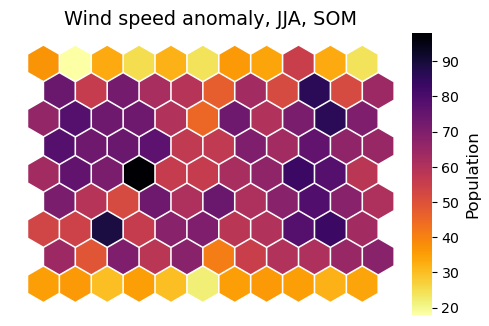

time: 543 ms


In [4]:
projected = net.project_onto_map(reduced)
indices = net.find_bmu_ix(reduced)
net.get_nodes_difference()
kwargs = {
    'cmap': cm.get_cmap('inferno').reversed(),
    'cbar_label': 'Population',
    'title': 'Wind speed anomaly, JJA, SOM'
}
fig, ax = sps.plots.plot_map(
    [[node.pos[0], node.pos[1]] for node in net.nodes_list],
    [np.sum(indices==i) for i in range(len(net.nodes_list))],
    net.polygons, show=False, **kwargs
)
plt.draw()
fcs = ax.collections[0].get_facecolors()
# for i, node in enumerate(net.nodes_list):
#     t = ax.text(node.pos[0], node.pos[1], s=i, ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='square', edgecolor=fcs[i], facecolor='white', pad=0.1))

In [5]:
df = pd.DataFrame(indices)

# create a new column with data shifted one space
df['shift'] = df[0].shift(-1)

# add a count column (for group by function)
df['count'] = 1

# groupby and then unstack, fill the zeros
trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

# normalise by occurences and save values to get transition matrix
trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values

time: 829 ms


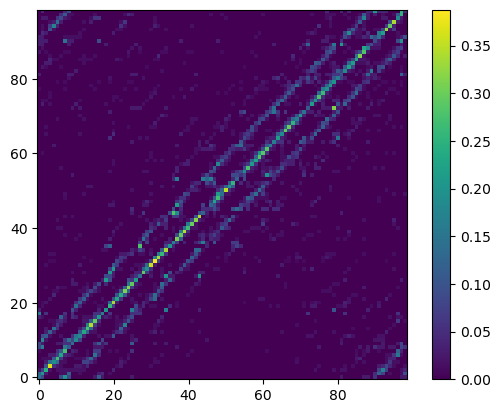

time: 699 ms


In [7]:
fig, ax = plt.subplots()
im = ax.imshow(trans_mat, origin='lower')
fig.colorbar(im, ax=ax)

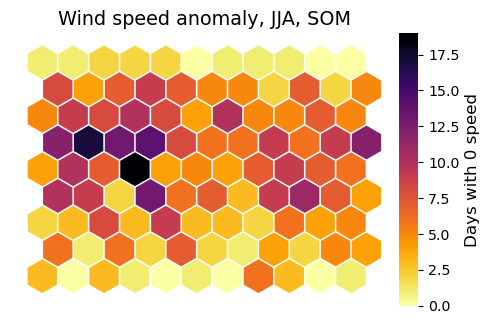

time: 1.39 s


In [8]:
diff = np.gradient(projected, axis=0)
diff = np.sqrt(diff[:, 0] ** 2 + diff[:, 1] ** 2)
meandiff = [np.sum(diff[indices==i] == 0) for i in range(len(net.nodes_list))]
kwargs = {
    'cmap': cm.get_cmap('inferno').reversed(),
    'cbar_label': 'Days with 0 speed',
    'title': 'Wind speed anomaly, JJA, SOM'
}
fig, ax = sps.plots.plot_map(
    [[node.pos[0], node.pos[1]] for node in net.nodes_list],
    meandiff,
    net.polygons, show=False, **kwargs
)
plt.draw()
fcs = ax.collections[0].get_facecolors()
# for i, node in enumerate(net.nodes_list):
#     t = ax.text(node.pos[0], node.pos[1], s=i, ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='square', edgecolor=fcs[i], facecolor='white', pad=0.1))

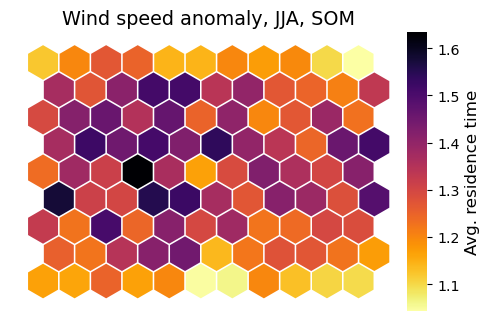

time: 942 ms


In [9]:
c = []
for i in range(nx * ny):
    s = pd.Series(indices == i)
    c.append((~s).cumsum()[s].value_counts().mean())
    
diff = np.gradient(projected, axis=0)
diff = np.sqrt(diff[:, 0] ** 2 + diff[:, 1] ** 2)
meandiff = [np.mean(diff[indices==i]) for i in range(len(net.nodes_list))]
kwargs = {
    'cmap': cm.get_cmap('inferno').reversed(),
    'cbar_label': 'Avg. residence time',
    'title': 'Wind speed anomaly, JJA, SOM'
}
fig, ax = sps.plots.plot_map(
    [[node.pos[0], node.pos[1]] for node in net.nodes_list],
    c, net.polygons, show=False, **kwargs, levels=[0, 1, 2, 3, 4, 5, 6, 7]
)
plt.draw()
fcs = ax.collections[0].get_facecolors()
# for i, node in enumerate(net.nodes_list):
#     t = ax.text(node.pos[0], node.pos[1], s=i, ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='square', edgecolor=fcs[i], facecolor='white', pad=0.1))

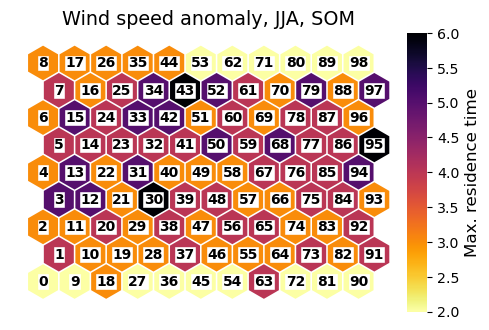

time: 1.73 s


In [12]:
c = []
for i in range(nx * ny):
    s = pd.Series(indices == i)
    c.append((~s).cumsum()[s].value_counts().max())
    
diff = np.gradient(projected, axis=0)
diff = np.sqrt(diff[:, 0] ** 2 + diff[:, 1] ** 2)
meandiff = [np.mean(diff[indices==i]) for i in range(len(net.nodes_list))]
kwargs = {
    'cmap': cm.get_cmap('inferno').reversed(),
    'cbar_label': 'Max. residence time',
    'title': 'Wind speed anomaly, JJA, SOM'
}
fig, ax = sps.plots.plot_map(
    [[node.pos[0], node.pos[1]] for node in net.nodes_list],
    c, net.polygons, show=False, **kwargs
)
plt.draw()
fcs = ax.collections[0].get_facecolors()
for i, node in enumerate(net.nodes_list):
    t = ax.text(node.pos[0], node.pos[1], s=i, ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='square', edgecolor=fcs[i], facecolor='white', pad=0.1))

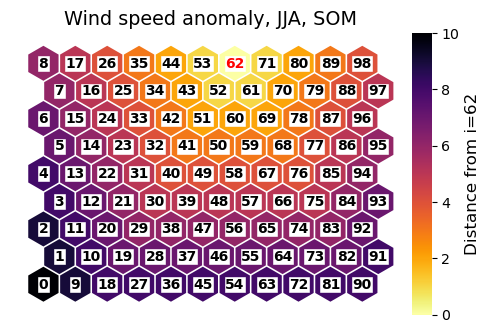

time: 976 ms


In [235]:
j = np.random.randint(0, 98)

kwargs = {
    'cmap': cm.get_cmap('inferno').reversed(),
    'cbar_label': f'Distance from i={j}',
    'title': 'Wind speed anomaly, JJA, SOM',
    'levels': np.arange(15)
}

distances = hexagonal_grid_distance(np.arange(99), j, nx)

fig, ax = sps.plots.plot_map(
    [[node.pos[0], node.pos[1]] for node in net.nodes_list],
    distances, net.polygons, show=False, **kwargs
)
plt.draw()
fcs = ax.collections[0].get_facecolors()
for i, node in enumerate(net.nodes_list):
    t = ax.text(node.pos[0], node.pos[1], s=i, ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='square', edgecolor=fcs[i], facecolor='white', pad=0.1))
    if i == j:
        t.set_color('red')

In [272]:
from somperf.metrics import combined_error, distortion, quantization_error, topographic_error
from somperf.utils.neighborhood import gaussian_neighborhood
from functools import partial

time: 962 ms


In [268]:
som = np.asarray([node.weights for node in net.nodes_list])
dist_fun = partial(hexagonal_grid_distance, nx=nx)
sigma = net.sigma
k = 100
d = euclidean_distances(x, som)
prec_dist = hexagonal_grid_distance(np.arange(nx * ny), np.arange(nx * ny), nx)
ce = combined_error(dist_fun, som, d=d)
di = distortion(dist_fun, gaussian_neighborhood(sigma), d=d)
kse = kruskal_shepard_error_vectorized(prec_dist, x, som, d)
qe = quantization_error(d=d)
te = topographic_error(dist_fun, d=d)
npr, tr = neighborhood_preservation_trustworthiness_vectorized(k, som, x, d)

time: 1min 23s


In [ ]:
iterator_size = enumerate(zip([1, 3, 5, 7, 9, 11, 11], [13, 4, 6, 8, 11, 13, 1]))
for _, (nx, ny) in iterator_size:
    print(nx, ny, end=' ')
    t = timer.time()
    net = sps.SOMNet(
        nx, ny, reduced, topology='hexagonal', 
        init='PCA', metric='cosine',
        neighborhood_fun='gaussian', PBC=True,
        random_seed=32, GPU=False, CUML=False,
        output_path="./"
    )
    net.train(
        train_algo='batch', start_learning_rate=0.01, epochs=-1, 
        batch_size=100
    )
    ttt = timer.time() - t
    filename = f'{DATADIR}/SOMs/trained_som_{reduced.shape[1]}_{nx}_{ny}'
    net.save_map(f'{filename}.npy')
    som = np.asarray([node.weights for node in net.nodes_list])
    dist_fun = partial(hexagonal_grid_distance, nx=nx)
    sigma = net.sigma
    k = 100
    d = euclidean_distances(x, som)
    prec_dist = hexagonal_grid_distance(np.arange(nx * ny), np.arange(nx * ny), nx)
    ce = combined_error(dist_fun, som, d=d)
    di = distortion(dist_fun, gaussian_neighborhood(sigma), d=d)
    kse = kruskal_shepard_error_vectorized(prec_dist, x, som, d)
    qe = quantization_error(d=d)
    te = topographic_error(dist_fun, d=d)
    npr, tr = neighborhood_preservation_trustworthiness_vectorized(k, som, x, d)
    perf = {
        'combined error': ce, 'distortion': di, 'kruskal_shepard_error': kse, 'quantization error': qe, 'topographic error': te, 
        'neighborhood preservation': npr, 'trustworthiness': te, 'time_to_train': ttt,
    }
    with open(f'{filename}.pkl', 'wb') as handle:
        pkl.dump(perf, handle)
    print(f'{timer.time() - t:.2f}s')

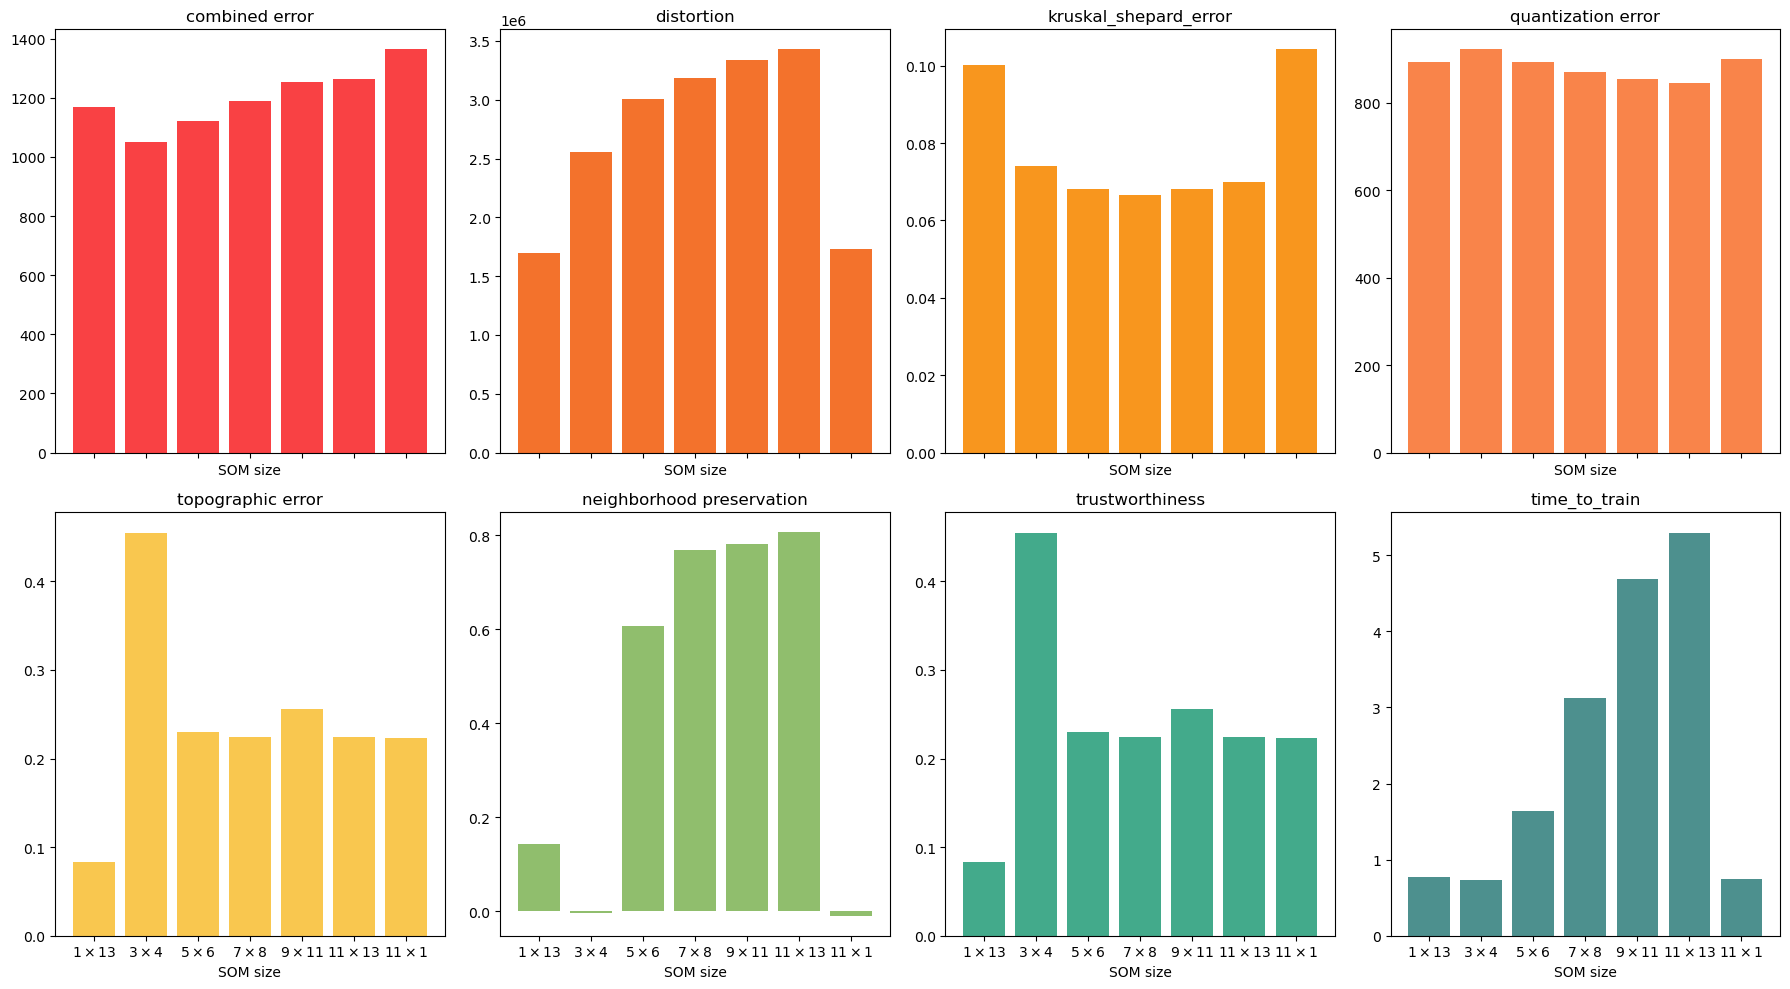

time: 3.2 s


In [320]:
fix, axes = plt.subplots(2, 4, tight_layout=True, figsize=(18, 10), sharex=True)
axes = axes.flatten()
iterator_size = enumerate(zip([1, 3, 5, 7, 9, 11, 11], [13, 4, 6, 8, 11, 13, 1]))
sizes = [f'${nx}' + r'\times' + f'{ny}$' for _, (nx, ny) in iterator_size]
iterator_size = enumerate(zip([1, 3, 5, 7, 9, 11, 11], [13, 4, 6, 8, 11, 13, 1]))
for i, (nx, ny) in iterator_size:
    filename = f'{DATADIR}/SOMs/trained_som_{reduced.shape[1]}_{nx}_{ny}'
    with open(f'{filename}.pkl', 'rb') as handle:
        perf = pkl.load(handle)
    for j, value in enumerate(perf.values()):
        axes[j].bar(i, value, width=0.8, color=COLORS10[j])
for j, key in enumerate(perf.keys()):
    axes[j].set_title(key)
    axes[j].set_xlabel('SOM size')
    axes[j].set_xticks(np.arange(len(sizes)))
    axes[j].set_xticklabels(sizes)

In [ ]:
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
centers = xr.DataArray(
    pca_results.inverse_transform([node.weights for node in net.nodes_list]).reshape(ny, nx, *thisda.shape[1:]), 
    coords={"y": np.arange(ny), "x": np.arange(nx), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(x=i, y=j) for j in range(ny) for i in range(nx - 1, -1, -1)]

In [ ]:
fig, axes, cbar = clusterplot(nx, ny, to_plot, 9, 8, cbar_ylabel="S300 [m/s]", clabels=[0])
axes = axes.reshape(nx, ny)
for i in range(nx):
    for j in range(ny):
        axes[i, j].set_title(f'Diff : {net.nodes_list[j * nx + (nx - i - 1)].difference:.4f}, Pop : {np.sum(indices==j * nx + (nx - i - 1))}')
plt.show()

## S300, kmedoids

In [ ]:
n_clu = 3
variable = "Wind"
level = "300"
region = "box_-60_30_15_80"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
diss = euclidean_distances(tbt)
results = kmedoids.fasterpam(diss, n_clu)
with open(f"{path}/kmed3_detrended_JJA_sqrtcos.pkl", "wb") as handle:
    pkl.dump(results, handle)
# results = KMeans(n_clu, n_init="auto").fit(tbt)
# with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "wb") as handle:
#     pkl.dump(results, handle)

In [ ]:
variable = "Wind"
level = "300"
region = "box_-60_30_15_80"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmed3_detrended_JJA_sqrtcos.pkl", "rb") as handle:
    results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
n_clu = len(results.medoids)
centers = thisda.isel(time=results.medoids).rename({'time': 'cluster'}).assign_coords({'cluster': np.arange(n_clu)})
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(1, n_clu, to_plot, 9, 16, cbar_ylabel="S300 [m/s]", clabels=[0])
plt.show()

In [ ]:
variable = "Wind"
level = "300"
region = "box_-60_30_15_80"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmed3_detrended_JJA_sqrtcos.pkl", "rb") as handle:
    results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
n_clu = len(results.medoids)
centers = thisda.isel(time=results.medoids).rename({'time': 'cluster'}).assign_coords({'cluster': np.arange(n_clu)})
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(1, n_clu, to_plot, 9, 16, cbar_ylabel="S300 [m/s]", clabels=[0])
plt.show()

In [ ]:
[np.mean(results.labels == i) for i in range(n_clu)]

### Predict hot spells

In [ ]:
n_clu=3
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_clusters = {}
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
detrended = xr.open_dataarray(f"{path}/detrended.nc") # Don't limit to summer here
minus = 21
plus = 5
for j, key in enumerate(keys):
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    hotspells_clusters[key] = []
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        to_predict = detrended.sel(time=pd.date_range(tsta, tend, freq="1D"))
        to_predict = to_predict.values.reshape(len(to_predict.time), -1)
        hotspells_clusters[key].append(results.predict(to_predict))
    hotspells_clusters[key] = xr.DataArray(
        np.stack(hotspells_clusters[key]).transpose(), 
        coords={"time": np.arange(-minus, plus + 1), "hotspell": dates}
    )
with open(f"{path}/hotspells_clusters.pkl", "wb") as handle:
    pkl.dump(hotspells_clusters, handle)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((2, len(keys), 2 * len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(3):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[int(i <= 1), j, (i % 2)::2] = i + (value == i).mean(dim="hotspell").values
class HandlerColormap(HandlerBase): # https://stackoverflow.com/questions/55501860/how-to-put-multiple-colormap-patches-in-a-matplotlib-legend
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle(
                [xdescent + i * width / self.num_stripes, ydescent], 
                width / self.num_stripes, 
                height, 
                fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                transform=trans,
            )
            stripes.append(s)
        return stripes

cmaps = [mpl.colormaps[cmap].resampled(256) for cmap in ["Blues", "Greens", "Reds", "Purples"]]
cmap = ListedColormap(np.concatenate([cmap(np.linspace(0, 1, 256)) for cmap in cmaps]))

fig, axes = plt.subplots(len(keys), 1, figsize=(15, 5))
norm = Normalize(0, len(cmaps))
for j, ax in enumerate(axes):
    ax.set_yticks([1])
    ax.set_yticklabels([list(hotspells_clusters.keys())[j]])
    if j==len(axes) - 1:
        ax.set_xticks(np.arange(hot_time[0] + 0.5, hot_time[-1] + 1.5))
        ax.set_xticklabels(np.arange(hot_time[0], hot_time[-1] + 1))
        ax.set_xlabel("Days around center")
    else:
        ax.set_xticks([])
    ax.set_frame_on(False)
    for i in range(2):
        ax.pcolormesh(
            np.arange(hot_time[0], hot_time[-1] + 1.1, .5), 
            np.arange(3), to_plot[:, j].reshape(2, len(hot_time) * 2), 
            cmap=cmap, norm=norm
        )
    ax.vlines(np.arange(hot_time[0] + 1, hot_time[-1] + 1), 0, 2, color="white", lw=4)
cmap_handles = [Rectangle((0, 0), 3, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=20) for cm in cmaps]))
cmap_labels = [f"regime {k + 1}" for k in range(4)]
axes[-1].legend(
    handles=cmap_handles, 
    labels=cmap_labels, 
    handler_map=handler_map, 
    fontsize=12,
    bbox_to_anchor=(1.13, 4.2),
    loc="upper right",
)
plt.subplots_adjust(hspace=0.1)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)
abs_freq = [np.mean(results.labels_ == i) for i in range(n_clu)]
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu, len(hotspells_clusters), len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(n_clu):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[i, j] = abs_freq[i] - (value == i).mean(dim="hotspell").values

fig, axes = plt.subplots(len(hotspells_clusters), 1, figsize=(15, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0, left=0.06)
for j, key in enumerate(hotspells_clusters):
    ax = axes[j]
#     ax.spines[["left", "right"]].set_visible(False)
    for i in range(n_clu):
        ax.plot(hot_time, to_plot[i, j], lw=2, color=COLORS5[i], label=f"Regime {i + 1}")
    ax.set_ylim([-0.5, 0.5])
    ax.set_yticks([-0.25, 0, 0.25])
    ax.set_yticklabels([-25, 0, 25])
    ax.text(-20.8, 0.21, key, fontweight="bold")
    ax.grid()
fig.supylabel('Regime relative occurence [%]')
ax.set_xlabel("Time around center [Days]")
ax.set_xlim([-21, 5])
ax.legend(bbox_to_anchor=(1.12, 3.53),)

## Z500

In [ ]:
n_clu = 4
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
# path = detrend(dataset, variable, level, region)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
results = KMeans(n_clu, n_init="auto").fit(tbt)
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(results, handle)

In [ ]:
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)
n_clu = len(results.cluster_centers_)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
centers = xr.DataArray(
    results.cluster_centers_.reshape(n_clu, *thisda.shape[1:]), 
    coords={"cluster": np.arange(n_clu), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(2, 2, to_plot, 11, 150, cbar_ylabel="Z500 [m]", clabels=False)
plt.show()

### Predict hot spells

In [ ]:
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_clusters = {}
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
detrended = xr.open_dataarray(f"{path}/detrended.nc") # Don't limit to summer here
minus = 21
plus = 5
for j, key in enumerate(keys):
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    hotspells_clusters[key] = []
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        to_predict = detrended.sel(time=pd.date_range(tsta, tend, freq="1D"))
        to_predict = to_predict.values.reshape(len(to_predict.time), -1)
        hotspells_clusters[key].append(results.predict(to_predict))
    hotspells_clusters[key] = xr.DataArray(
        np.stack(hotspells_clusters[key]).transpose(), 
        coords={"time": np.arange(-minus, plus + 1), "hotspell": dates}
    )
with open(f"{path}/hotspells_clusters.pkl", "wb") as handle:
    pkl.dump(hotspells_clusters, handle)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu // 2, len(keys), 2 * len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(4):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[int(i <= 1), j, (i % 2)::2] = i + (value == i).mean(dim="hotspell").values
class HandlerColormap(HandlerBase): # https://stackoverflow.com/questions/55501860/how-to-put-multiple-colormap-patches-in-a-matplotlib-legend
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle(
                [xdescent + i * width / self.num_stripes, ydescent], 
                width / self.num_stripes, 
                height, 
                fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                transform=trans,
            )
            stripes.append(s)
        return stripes

cmaps = [mpl.colormaps[cmap].resampled(256) for cmap in ["Blues", "Greens", "Reds", "Purples"]]
cmap = ListedColormap(np.concatenate([cmap(np.linspace(0, 1, 256)) for cmap in cmaps]))

fig, axes = plt.subplots(len(keys), 1, figsize=(15, 5))
norm = Normalize(0, len(cmaps))
for j, ax in enumerate(axes):
    ax.set_yticks([1])
    ax.set_yticklabels([list(hotspells_clusters.keys())[j]])
    if j==len(axes) - 1:
        ax.set_xticks(np.arange(hot_time[0] + 0.5, hot_time[-1] + 1.5))
        ax.set_xticklabels(np.arange(hot_time[0], hot_time[-1] + 1))
        ax.set_xlabel("Days around center")
    else:
        ax.set_xticks([])
    ax.set_frame_on(False)
    for i in range(2):
        ax.pcolormesh(
            np.arange(hot_time[0], hot_time[-1] + 1.1, .5), 
            np.arange(3), to_plot[:, j].reshape(2, len(hot_time) * 2), 
            cmap=cmap, norm=norm
        )
    ax.vlines(np.arange(hot_time[0] + 1, hot_time[-1] + 1), 0, 2, color="white", lw=4)
cmap_handles = [Rectangle((0, 0), 3, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=20) for cm in cmaps]))
cmap_labels = [f"regime {k + 1}" for k in range(4)]
axes[-1].legend(
    handles=cmap_handles, 
    labels=cmap_labels, 
    handler_map=handler_map, 
    fontsize=12,
    bbox_to_anchor=(1.13, 4.2),
    loc="upper right",
)
plt.subplots_adjust(hspace=0.1)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
with open(f"{path}/kmeans_ERA5_detrended.pkl", "rb") as handle:
    results = pkl.load(handle)
n_clu = 4
abs_freq = [np.mean(results.labels_ == i) for i in range(n_clu)]
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu, len(hotspells_clusters), len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(n_clu):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[i, j] = abs_freq[i] - (value == i).mean(dim="hotspell").values

fig, axes = plt.subplots(len(hotspells_clusters), 1, figsize=(15, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0, left=0.06)
for j, key in enumerate(hotspells_clusters):
    ax = axes[j]
#     ax.spines[["left", "right"]].set_visible(False)
    for i in range(n_clu):
        ax.plot(hot_time, to_plot[i, j], lw=2, color=COLORS5[i], label=f"Regime {i + 1}")
    ax.set_ylim([-0.5, 0.5])
    ax.set_yticks([-0.25, 0, 0.25])
    ax.set_yticklabels([-25, 0, 25])
    ax.text(-20.8, 0.21, key, fontweight="bold")
    ax.grid()
fig.supylabel('Regime relative occurence [%]')
ax.set_xlabel("Time around center [Days]")
ax.set_xlim([-21, 5])
ax.legend(bbox_to_anchor=(1.12, 3.53),)

# PCA

## S300

In [ ]:
n_components = 20
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_results = pca(n_components=n_components, whiten=True).fit(tbt)

In [ ]:
centers = xr.DataArray(
    pca_results.components_.reshape(n_components, *thisda.shape[1:]), 
    coords={"component": np.arange(n_components), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(component=i) for i in range(n_components)]
levels = 10
lower, upper = -0.045, 0.045
fig, axes, cbar = clusterplot(6, 4, to_plot, levels, 0.045)

In [ ]:
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(pca_results, handle)

## Z500

In [ ]:
from sklearn.decomposition import PCA as pca
n_components = 20
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_results = pca(n_components=n_components, whiten=True).fit(tbt)

In [ ]:
centers = xr.DataArray(
    pca_results.components_.reshape(n_components, *thisda.shape[1:]), 
    coords={"component": np.arange(n_components), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
projection = ccrs.LambertConformal(
    central_longitude=np.mean(thisda.lon.values),
)
lon = thisda["lon"].values
lat = thisda["lat"].values
fig, axes = plt.subplots(5, 4, figsize=(20, 25), subplot_kw={"projection": projection}, constrained_layout=True)
extent = [np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)]
boundary = make_boundary_path(*extent)
levels = 10
cmap = "seismic"
lower, upper = -0.045, 0.045
levels = np.delete(np.append(np.linspace(lower, 0, levels), np.linspace(0, upper, levels)), [levels - 1, levels])
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
im = cm.ScalarMappable(norm=norm, cmap=cmap)
axes = axes.flatten()
for i in range(n_components):
    axes[i].contourf(
        lon,
        lat,
        centers.isel(component=i), 
        transform=ccrs.PlateCarree(),
        levels=levels, 
        cmap=cmap, 
        norm=norm,
        extend="both",
    )
    axes[i].contour(
        lon,
        lat,
        centers.isel(component=i), 
        transform=ccrs.PlateCarree(),
        levels=levels, 
        colors="k",
    )
    axes[i].set_boundary(boundary, transform=ccrs.PlateCarree())
    axes[i].add_feature(COASTLINE)
    axes[i].add_feature(BORDERS)
    axes[i].set_title(f"{pca_results.explained_variance_ratio_[i] * 100:.2f} %")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Z500 [m]")
# _ = cbar.ax.set_yticks(np.concatenate([np.arange(-0.045, -0.004, 0.005), np.arange(0.005, 0.046, 0.005)]))
plt.show()

In [ ]:
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(pca_results, handle)

# K means on EOFs

## S300

In [ ]:
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "rb") as handle:
    pca_results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
reduced = pca_results.transform(tbt)

In [ ]:
n_clu=3
pca_kmeans_results = KMeans(n_clu, n_init="auto").fit(reduced)

In [ ]:
# with open("kmeans_ERA5_detrended.pkl", "rb") as handle:
#     results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
centers = xr.DataArray(
    pca_results.inverse_transform(pca_kmeans_results.cluster_centers_).reshape(n_clu, *thisda.shape[1:]), 
    coords={"cluster": np.arange(n_clu), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
projection = ccrs.LambertConformal(
    central_longitude=np.mean(thisda.lon.values),
)
lon = thisda["lon"].values
lat = thisda["lat"].values
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5), subplot_kw={"projection": projection}, constrained_layout=True)
extent = [np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)]
boundary = make_boundary_path(*extent)
nlevels = 5
cmap = "seismic"
lower, upper = -8, 8
levels0 = np.delete(np.append(np.linspace(lower, 0, nlevels), np.linspace(0, upper, nlevels)), nlevels - 1)
levels = np.delete(levels0, nlevels - 1)
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
im = cm.ScalarMappable(norm=norm, cmap=cmap)
axes = axes.flatten()
for i in range(n_clu):
    axes[i].contourf(
        lon,
        lat,
        centers.isel(cluster=i), 
        transform=ccrs.PlateCarree(),
        levels=levels, cmap=cmap, norm=norm,
        extend="both",
    )
    cs = axes[i].contour(
        lon,
        lat,
        centers.isel(cluster=i), 
        transform=ccrs.PlateCarree(),
        levels=levels0, colors="k",
    )
    axes[i].clabel(cs, cs.levels, inline=True, fontsize=10)
    axes[i].set_boundary(boundary, transform=ccrs.PlateCarree())
    axes[i].add_feature(COASTLINE)
    axes[i].add_feature(BORDERS)
    axes[i].set_title(f"Regime {i + 1}, {np.sum(pca_kmeans_results.labels_ == i) / len(pca_kmeans_results.labels_) * 100:.2f}%")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Z500 [m]")
# _ = cbar.ax.set_yticks(np.concatenate([np.arange(-150, 20, 30), np.arange(30, 151, 30)]))
plt.show()

## Z500

In [ ]:
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "rb") as handle:
    pca_results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
reduced = pca_results.transform(tbt)

In [ ]:
n_clu=4
pca_kmeans_results = KMeans(n_clu, n_init="auto").fit(reduced)

In [ ]:
# with open("kmeans_ERA5_detrended.pkl", "rb") as handle:
#     results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
centers = xr.DataArray(
    pca_results.inverse_transform(pca_kmeans_results.cluster_centers_).reshape(n_clu, *thisda.shape[1:]), 
    coords={"cluster": np.arange(n_clu), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
projection = ccrs.LambertConformal(
    central_longitude=np.mean(thisda.lon.values),
)
lon = thisda["lon"].values
lat = thisda["lat"].values
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5), subplot_kw={"projection": projection}, constrained_layout=True)
extent = [np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)]
boundary = make_boundary_path(*extent)
levels = 11
cmap = "seismic"
lower, upper = -150, 150
levels = np.delete(np.append(np.linspace(lower, 0, levels), np.linspace(0, upper, levels)), [levels - 1, levels])
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
im = cm.ScalarMappable(norm=norm, cmap=cmap)
axes = axes.flatten()
for i in range(n_clu):
    axes[i].contourf(
        lon,
        lat,
        centers.isel(cluster=i), 
        transform=ccrs.PlateCarree(),
        levels=levels, cmap=cmap, norm=norm,
        extend="both",
    )
    axes[i].contour(
        lon,
        lat,
        centers.isel(cluster=i), 
        transform=ccrs.PlateCarree(),
        levels=levels, colors="k",
    )
    axes[i].set_boundary(boundary, transform=ccrs.PlateCarree())
    axes[i].add_feature(COASTLINE)
    axes[i].add_feature(BORDERS)
    axes[i].set_title(f"Regime {i + 1}, {np.sum(pca_kmeans_results.labels_ == i) / len(pca_kmeans_results.labels_) * 100:.2f}%")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Z500 [m]")
_ = cbar.ax.set_yticks(np.concatenate([np.arange(-150, 20, 30), np.arange(30, 151, 30)]))
plt.show()

# OPP from EOFs (optimal $T_1$, TODO $T_2$) 

## S300

In [ ]:
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "rb") as handle:
    pca_results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
reduced = pca_results.transform(tbt)

In [ ]:
da_reduced = xr.DataArray(reduced, coords={"time": thisda.time.values, "projection": np.arange(n_components)})

lag_max = 15 # days
autocorrs = []
for j in range(lag_max):
    autocorrs.append(np.cov(da_reduced.values[j:], da_reduced.shift(time=j).values[j:], rowvar=False)[n_components:, :n_components])

autocorrs = np.asarray(autocorrs)
M = autocorrs[0] + np.sum([autocorrs[i] + autocorrs[i].transpose() for i in range(1, lag_max)], axis=0)

eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(autocorrs[0]) @ M)

OPPs_realspace = pca_results.inverse_transform(eigenvecs)

In [ ]:
centers = xr.DataArray(
    OPPs_realspace.reshape(n_components, *thisda.shape[1:]), 
    coords={"component": np.arange(n_components), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat.values))[None, :, None]
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(1, n_clu, to_plot, 9, 16, cbar_ylabel="S300 [m/s]", clabels=[0])
for i in range(n_components):
    axes[i].set_title(eigenvals[i])

## Z500

In [ ]:
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/pca_ERA5_detrended.pkl", "rb") as handle:
    pca_results = pkl.load(handle)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
reduced = pca_results.transform(tbt)

In [ ]:
da_reduced = xr.DataArray(reduced, coords={"time": thisda.time.values, "projection": np.arange(n_components)})

lag_max = 15 # days
autocorrs = []
for j in range(lag_max):
    autocorrs.append(np.cov(da_reduced.values[j:], da_reduced.shift(time=j).values[j:], rowvar=False)[n_components:, :n_components])

autocorrs = np.asarray(autocorrs)
M = autocorrs[0] + np.sum([autocorrs[i] + autocorrs[i].transpose() for i in range(1, lag_max)], axis=0)

eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(autocorrs[0]) @ M)

OPPs_realspace = pca_results.inverse_transform(eigenvecs)

In [ ]:
centers = xr.DataArray(
    OPPs_realspace.reshape(n_components, *thisda.shape[1:]), 
    coords={"component": np.arange(n_components), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(1, n_clu, to_plot, 11, 0.05, cbar_ylabel="S300 [m/s]", clabels=[0])
for i in range(n_components):
    axes[i].set_title(eigenvals[i])
plt.show()

# Hidden Markov Model

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
Y = Zoo["Lat_detrended"].isel(time=Zoo.time.dt.season=="DJF").values

In [ ]:
n_components = 3
n_sel = 50
n_sam = 4500
means = []
sigmas = []
transmats = []
for i in range(n_sel):
    ghmm = GaussianHMM(n_components=n_components).fit(Y[:, None])
    transmats.append(ghmm.transmat_)
    means.append(ghmm.means_[:, 0])
    sigmas.append(ghmm.covars_[:, 0, 0])
# im = plt.imshow(ghmm.transmat_)
# plt.colorbar(im)

In [ ]:
means = np.stack(means)
sigmas = np.stack(sigmas)
transmats = np.stack(transmats)
idx2 = np.argsort(means, axis=1)
means = np.take_along_axis(means, idx2, axis=1)
sigmas = np.take_along_axis(sigmas, idx2, axis=1)
transmatss = np.take_along_axis(transmats, idx2[:, :, np.newaxis], axis=1)
transmatss = np.take_along_axis(transmatss, idx2[:, np.newaxis, :], axis=2)
mean = np.mean(means, axis=0)
sigma = np.mean(sigmas, axis=0)
transmat = np.mean(transmatss, axis=0)
c = np.real(np.log(np.linalg.eigvals(transmat).astype(np.complex128)))
c[np.isclose(c, 0)] = 0
for i in range(n_components):
    thisnorm = normal_dist(loc=mean[i], scale=np.sqrt(sigma[i]))
    X = np.linspace(thisnorm.ppf(0.005), thisnorm.ppf(0.995), 100)
    plt.plot(X, thisnorm.pdf(X) / n_components, label=f"$c={c[i]:.2f}$")
plt.plot(*kde(Y, season=None, bins=np.arange(-30, 30.1, 0.5), scaled=False, return_x=True, bw_method=0.2), label="JLI, KDE")
plt.legend()

In [ ]:
meanghmm = GaussianHMM(n_components=3, covariance_type='full')
meanghmm.transmat_ = transmat
meanghmm.means_ = mean.reshape(3, 1)
meanghmm.covars_ = sigma.reshape(3, 1, 1)
meanghmm.startprob_ = [0, 0, 1]

In [ ]:
Zda = xr.open_dataarray(f"{DATADIR}/ERA5/Geopotential/500/north_atlantic/detrended.nc").isel(time=Zoo.time.dt.season=="DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Zda.isel(time=states==i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(1, n_components, to_plot, 11, 150, cbar_ylabel="Z500 [m]", cmap="PRGn")
plt.show()

In [ ]:
Sda = xr.open_dataarray(f"{DATADIR}/ERA5/Wind/300/box_-90_30_30_80/s_detrended.nc")[1:].isel(time=Zoo.time.dt.season=="DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Sda.isel(time=states==i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(1, n_components, to_plot, 7, 12, cbar_ylabel="S300 [m/s]")
plt.show()

## Length of events

In [ ]:
def runs_of_ones_array(bits): # https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], bits, [0]))
    # get 1 at run starts and -1 at run ends
    difs = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends, = np.where(difs < 0)
    return run_starts, run_ends - run_starts

fig, ax = plt.subplots()
for i in range(meanghmm.n_components):
    thisseq = states==i
    _, durations = runs_of_ones_array(thisseq)
    dur, occu = np.unique(durations, return_counts=True)
    durind = np.argsort(dur)
    dur = dur[durind]
    occu = occu[durind] / np.amax(occu)
    ax.plot(dur, occu, label=f"$\mu = {mean[i]:.2f}$° N, $c={c[i]:.2f}$")
ax.legend()

# Quasi stationary states

In [ ]:
# n_components = 20
variable = "Wind"
level = "300"
dataset = "ERA5"
region = "box_-60_30_30_80"
thisda = xr.open_dataarray(f"{path}/s_detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season=="JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_resultsw = pca(n_components=100, whiten=True).fit(tbt)
pca_results = pca(n_components=100, whiten=False).fit(tbt)
plt.plot(np.cumsum(pca_results.explained_variance_ratio_))
plt.plot(np.cumsum(pca_resultsw.explained_variance_ratio_))

In [ ]:
n_components = 100
centers = xr.DataArray(
    pca_results.components_.reshape(n_components, *thisda.shape[1:]), 
    coords={"component": np.arange(n_components), "lat": thisda.lat.values, "lon": thisda.lon.values},
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(component=i) for i in range(24)]
levels = 10
lower, upper = -0.045, 0.045
fig, axes, cbar = clusterplot(6, 4, to_plot, levels, 0.045)
plt.show()

# Dynamical systems theory

In [ ]:
import CDSK as ck

In [ ]:
local_indices = []
for year in YEARSPL:
    print(year)
    da = xr.open_dataset(f"{DATADIR}/ERA5/Wind/300/north_atlantic/{year}.nc")["u"]
    local_indices.append(ck.dynamical_local_indexes(da.values.reshape(len(da.time), -1, 1)))
# todo : classify wind using Lachmy & Harnik 2016

In [ ]:
ld = xr.DataArray(np.concatenate([li[0].flatten() for li in local_indices]), coords={"time": DATERANGEPL}, name="ld")
theta = xr.DataArray(np.concatenate([li[1].flatten() for li in local_indices]), coords={"time": DATERANGEPL}, name="theta")

In [ ]:
ld.to_netcdf("ld_u300_NA.nc")
theta.to_netcdf("theta_u300_NA.nc")

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.subplots_adjust(hspace=0)
ld.plot(ax=axes[0])
persistence = 1 / theta
q95 = np.quantile(persistence, 0.95)
theta.plot(ax=axes[1])
theta.isel(time=persistence>=q95).plot(color="red", ls="", marker="x")

## HMM on theta, because it looks ladder-y

In [ ]:
Y_theta = theta.values.reshape((-1, 1))
n_components = 4
ghmm_theta = GaussianHMM(n_components=n_components).fit(Y_theta)
belongs = ghmm_theta.predict(Y_theta)
theta.plot()
for i in range(n_components):
    theta.isel(time=belongs==i).plot(marker="x", color=COLORS10[i%10], ls="")

In [ ]:
fig, ax = plt.subplots()
for i, s in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax.scatter(ld.isel(time=ld.time.dt.season==s), theta.isel(time=ld.time.dt.season==s), s=2, label=s, c=COLORS5[i])
# plt.scatter(ld[20000:], theta[5:])
ax.set_xlim([0, 25])
ax.legend()

In [ ]:
EKE = xr.open_dataarray(f"{DATADIR}/NCEP/processed/EDG/EKE.nc").sel(time=DATERANGEPL)

In [ ]:
EKE.lat

In [ ]:
mean_EKE_NA = EKE.isel(lat=(EKE.lat >= 20)&(EKE.lat <= 80), lon=(EKE.lon >= -30) & (EKE.lon <= 90)).mean(dim=["lon", "lat"])
mean_EKE_NA.plot()

In [ ]:
fig, ax = plt.subplots()
idx = np.argsort(mean_EKE_NA).values
hi = ax.scatter(ld[idx], theta[idx], c=mean_EKE_NA[idx], s=mean_EKE_NA[idx], cmap="cool", vmin=0, vmax=140)
fig.colorbar(hi)
ax.set_xlim([-1, 200])

In [ ]:
da.differentiate(coord="time").mean(dim=["longitude", "latitude"]).plot()

In [ ]:
da

## Residence times

# Recurrence

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    print(key, len(dates))
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D")
        tend = date + np.timedelta64(plus, "D")
        hotspells[key].append(pd.date_range(tsta, tend, freq="1D"))

hotspells_per_year = {year: {key: [] for key in keys} for year in YEARSPL}
for key, hotspell in hotspells.items():
    for series in hotspell:
        year = series[0].year
        tsta = max(0, (series[0] - da.time.isel(time=da.time.dt.year==year).values[0]).days)
        tend = min(92, (series[-1] - da.time.isel(time=da.time.dt.year==year).values[0]).days)
        hotspells_per_year[year][key].append([tsta, tend])

## Recurrence plots without PCA

In [ ]:
variable = "Wind"
level = "300"
region = "box_-60_90_30_80"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
da = xr.open_dataarray(f"{path}/s_detrended.nc")
da = da.isel(time=da.time.dt.season=="JJA")
da = (da * np.sqrt(degcos(da.lat)))
distances = xr.DataArray(np.zeros((len(YEARSPL), 92, 92)), coords={"year": YEARSPL, "d1": np.arange(92), "d2": np.arange(92)})
for i, year in enumerate(YEARSPL):
    thisda = da.isel(time=da.time.dt.year==year).values.reshape(92, -1)
    distances[i, :, :] = euclidean_distances(thisda, thisda)
# indexer = xr.DataArray(distda.year1.values, dims="year")
# distda_reduced = distda.isel(year1=indexer, year2=indexer)

In [ ]:
fig, axes = plt.subplots(13, 5, figsize=(12, 12*13/5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
axes = axes.flatten()
cmap = "Reds"
thresh = 1200
for i, ax in enumerate(axes):
    if i == 63:
        ax.imshow(distances.mean(dim="year").values < thresh, cmap=cmap, origin="lower")
        ax.text(1, 81, "Average", fontweight="bold")
        ax.text(55, 3, f"$d<{thresh:.0f}$")
        ax = axes[64]
        break
    else:
        for j, (key, hotspell) in enumerate(hotspells_per_year[YEARSPL[i]].items()):
            for pair in hotspell:
                ax.fill_between(np.arange(pair[0], pair[1]), 0, 91, alpha=0.5, color=COLORS5[j])
        ax.imshow(distances.isel(year=i).values < thresh, cmap=cmap, origin="lower")
        ax.text(1, 81, f"{YEARSPL[i]}", fontweight="bold")
    ax.set_xticks([0, 30, 61])
    ax.set_yticks([0, 30, 61])
    ax.grid()
ax.legend(handles=[Patch(color=COLORS5[i], label=keys[i]) for i in range(len(keys))])

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(19, 15.2), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
norm = Normalize(vmin=0, vmax=2400, clip=True)
axes = axes.flatten()
cmap = "CMRmap"
im = cm.ScalarMappable(norm=norm, cmap=cmap)
thresh = 1300
for i, ax in enumerate(axes):
    if i > 62:
        d = distances.mean(dim="year").values
        ax.text(1, 81, "Average", fontweight="bold")
    else:
        d = distances.isel(year=i).values
        ax.text(1, 81, f"{YEARSPL[i]}", fontweight="bold")
        for j, (key, hotspell) in enumerate(hotspells_per_year[YEARSPL[i]].items()):
            for pair in hotspell:
                ax.fill_between(np.arange(pair[0], pair[1]), 0, 91, alpha=0.5, color=COLORS5[j])
    d[d >= thresh] = 3000
    ax.imshow(d, norm=norm, cmap=cmap, origin="lower")
    ax.set_xticks([0, 30, 61])
    ax.set_yticks([0, 30, 61])
    ax.grid()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Distance")

# Duncan's hotspells

### Create hotspells file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    print(key, len(dates))
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = xr.open_dataset(f"{DATADIR}/{dataset}/Wind/300/dailymean/{np.datetime_as_string(date, unit='Y')}.nc")
        thisds = thisds.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells[key].append(thisds)
    hotspells[key] = xr.concat(hotspells[key], dim="hotspell").assign_coords({"hotspell": dates})
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "wb") as handle:
    pkl.dump(hotspells, handle)

- Replace time coords with range(21), keep track of the center date (or all time as index but not coord) : done
- create aggregates : mean, std, correlation with T, look at individuals for all clusters
- compare with duncan's plot, also get boundaries of the clusters
- cluster wind myself and compare backwards

### Study hotspells

In [ ]:
dataset = "ERA5"
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "rb") as handle:
    hotspells = pkl.load(handle)

meanwind_hotspell = xr.concat([hotspell.mean(dim="hotspell") for hotspell in hotspells.values()], dim="region").assign_coords({"region": list(hotspells.keys())})

In [ ]:
meanwind_hotspell_NA = meanwind_hotspell.sel(latitude=np.arange(30, 90, 0.5)).load()
meanwind_hotspell_NA["s"] = np.sqrt(meanwind_hotspell_NA["u"] ** 2 + meanwind_hotspell_NA["v"] ** 2)
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values
meanwind_hotspell_NA.to_netcdf(f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc")

In [ ]:
dataset = "ERA5"
meanwind_hotspell_NA = xr.open_dataset(f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc")
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values

In [ ]:
ticker_region = pnw.Select(name="Region", options=meanwind_hotspell_NA.region.values.tolist())
ticker_variable = pnw.Select(name="Component", options=list(meanwind_hotspell_NA.data_vars.keys()))
ticker_kind= pnw.Select(name="Kind", options=["contour", "contourf", "quadmesh"])

tsta, tend = int(np.amin(meanwind_hotspell_NA.time.values)), int(np.amax(meanwind_hotspell_NA.time.values))
slider = pnw.IntSlider(name="Day around center", start=tsta, end=tend)

extent = [np.amin(lon_NA), np.amax(lon_NA) + 0.5, np.amin(lat_NA), np.amax(lat_NA) + 0.5]
# boundary = mpath.Path(np.stack([np.linspace(180, 0, 361), np.full(361, 30)]).transpose())
boundary = make_boundary_path(*extent)
boundary.vertices = boundary.vertices[(boundary.vertices[:, 1] == 30) | (boundary.vertices[:, 1] == 90)]
nlevels = 11
levels0 = np.delete(np.append(np.linspace(-30, 0, nlevels), np.linspace(0, 30, nlevels)), nlevels - 1)
levels = np.delete(levels0, nlevels - 1)
cmap="seismic"
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
im = cm.ScalarMappable(norm=norm, cmap=cmap)

def crop_axis(plot, element):
    b = plot.state
    b.axes[0].set_boundary(boundary, transform=ccrs.PlateCarree())
    if len(b.axes) == 1:
        b.colorbar(im, ax=b.axes[0], spacing="proportional")
    else:
        b.get_figure().colorbar(im, cax=b.axes[1], spacing="proportional")
    b.axes[1].set_yticks(levels)

a = meanwind_hotspell_NA.interactive.sel(region=ticker_region, time=slider).hvplot(
    kind=ticker_kind, 
    x="longitude", y="latitude", z=ticker_variable, 
    cmap="seismic", 
    colorbar=False,
    color=None,
    linewidth=1.5, 
    symmetric=True,
    projection="NorthPolarStereo",
    geo=True, 
    coastline='110m', 
    levels=levels,
    xlabel=None,
    ylabel=None,
    xaxis=None,
    yaxis=None,
    title=ticker_variable,
    width=700,
    height=400
)
# a = a.opts(hooks=[crop_axis])

pn.Row(a.widgets(), a.holoviews())

## Zoo during hotspells

### Create hotspells_zoo file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_Zoo = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
Zookeys = list(Zoo.data_vars.keys()) # copy and not view !
minus = 21
plus = 5
for varname in Zookeys:
    if varname[-11:].split('_')[-1] == "climatology":
        del Zoo[varname]
for j, key in enumerate(keys):
    hotspells_Zoo[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = Zoo.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)}).reset_index("dayofyear", drop=True)
        hotspells_Zoo[key].append(thisds)
    hotspells_Zoo[key] = xr.concat(hotspells_Zoo[key], dim="hotspell").assign_coords({"hotspell": dates})
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "wb") as handle:
    pkl.dump(hotspells_Zoo, handle)

### Plot

In [ ]:
%matplotlib inline
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "rb") as handle:
    hotspells_Zoo = pkl.load(handle)

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 25), tight_layout=True)
axes = axes.flatten()
for k, key in enumerate([f"{key}_anomaly" for key in ZOO]):
    ax = axes[k]
    for i, regionkey in enumerate(hotspells_Zoo):
        to_plot = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(np.abs(to_plot))).plot(ax=ax, label=regionkey, color=COLORS10[(2 * i) % 9], lw=2)
        # ax.fill_between(
        #     to_plot.time, 
        #     *(np.quantile(hotspells_Zoo[regionkey][key], [0.05, 0.95], axis=0) / np.amax(np.abs(to_plot)).values), 
        #     color=COLORS10[(2 * i) % 9],
        #     alpha=0.1,
        # )
    ax.set_title(key)
    ax.set_xlabel("Time around center")
    ax.set_ylabel("Normalized anomaly")
    if k==9:
        ax.legend(ncol=2)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
x = hotspells_Zoo["South"].time.values
tsta, tend = x[[0, -1]]
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate([f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]):
        norm = np.amax(np.abs(Zoo[key].isel(time=Zoo.time.dt.season=="JJA")))
        to_plot = (hotspells_Zoo[regionkey][key] / norm).mean(dim="hotspell")
        quantiles = (hotspells_Zoo[regionkey][key] / norm).quantile([0.1, 0.9], dim="hotspell")
        ax.plot(x, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
        ax.fill_between(x, *quantiles, color=COLORS5[i % 5], alpha=0.5)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("Normalized anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k==5:
        ax.legend(ncol=2)

### As p-values

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_Zoo["South"].time.values[[0, -1]]
keys = [f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]
cdfs = {key: cdf(Zoo[key].isel(time=Zoo.time.dt.season=="JJA")) for key in keys}
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate(keys):
        x, y = cdfs[key]
        base = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        to_plot = y[np.searchsorted(x, base)]
        ax.plot(base.time, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("p-value of anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k==5:
        ax.legend(ncol=2)

#### How gaussian are those timeseries ?

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15), tight_layout=True)
axes = axes.flatten()
varkeys = [f"{key}_anomaly" for key in ZOO]
cdfs = {key: cdf(Zoo[key]) for key in varkeys}
for i, key in enumerate(varkeys):
    ax = axes[i]
    x, y = cdfs[key]
    ax.plot(x, y, "k", zorder=4)
    y2 = normal_dist.cdf(x, loc=np.mean(Zoo[key]), scale=np.std(Zoo[key], ddof=1))
    ax.plot(x, y2, "b--")
    ax.plot(x, np.abs(y-y2), "r")
    ax.set_title(f"{np.linalg.norm(np.abs(y-y2)) / len(y):.2e}")
    ax.set_xlabel(key)
    ax.set_ylabel("$p$")
    ax.grid()

## Dynamical indices during hotspells

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_dynind = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
ld = xr.open_dataarray(f"{datadir}/ld.nc")
theta = xr.open_dataarray(f"{datadir}/theta.nc")
indices = xr.Dataset({"ld": ld, "theta": theta})
indikeys = list(indices.data_vars.keys()) # copy and not view !
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells_dynind[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D")
        tend = date + np.timedelta64(plus, "D")
        thisds = indices.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells_dynind[key].append(thisds)
    hotspells_dynind[key] = xr.concat(hotspells_dynind[key], dim="hotspell").assign_coords({"hotspell": dates})
with open(f"{DATADIR}/{dataset}/processed/hotspells_dynind.pkl", "wb") as handle:
    pkl.dump(hotspells_dynind, handle)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_dynind["South"].time.values[[0, -1]]
for k, regionkey in enumerate(hotspells_dynind):
    ax = axes[k]
    for i, key in enumerate(hotspells_dynind["South"].data_vars):
        to_plot = hotspells_dynind[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(to_plot)).plot(ax=ax, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
    ax.set_title(regionkey)
    ax.set_xlabel("Day around center")
    ax.set_ylabel("Normalized index")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k==5:
        ax.legend(ncol=2)

# Misc

### Create_plot

In [ ]:
def create_plot(to_plot, titles, levels, twolevel=False, startindex=-1):
    # Figure
    transform = ccrs.PlateCarree()
    projection = transform
    if twolevel:
        fig, axes = plt.subplots(
            2,
            int(len(to_plot) / 2),
            subplot_kw={"projection": projection}, constrained_layout=True #, figsize=(6 * len(to_plot) // 2, 13)
        )
    else:
        fig, axes = plt.subplots(
            1, len(to_plot), subplot_kw={"projection": projection}, constrained_layout=True, figsize=(3.5 * len(to_plot), 6)
        )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Add coastline and boarders
    coastline = feat.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = feat.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=startindex).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
        )

        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
        ax.set_title(f"Day {startindex}, {titles[j]}, g.a : {np.mean(to_plot[j][startindex]):.2f}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=i).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.2f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all

### Fetch

In [ ]:
longname = {
    "u": "U-component of wind",
    "v": "V-component of wind",
    "w": "W-component of wind",
    "z": "Geopotential",
    "t": "Temperature",
    "vo": "Relative vorticity",
    "q": "Specific humidity",
    "r": "relative humidity"
    
}
variablemap = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for var in ["u", "v", "vo"] 
    for lev in range(700, 901, 50)
}
var = "z"
vm2 = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for lev in [300, 500]
}

variablemap.update(vm2)
variablemap["t850"] = ["t", "PL", 850, f"{longname['t']} at 850 hPa"]

### PV calculations

In [ ]:
ds = xr.open_mfdataset(fn(DATERANGEML[0], which="ML")[:1], combine="nested", concat_dim="time")
ds["P"] = (ds["hybm"] * ds["PS"] + ds["hyam"]).isel(lev_2=0).drop("lev_2").rename({"nhym": "lev"})
ds["P"].attrs["units"] = "Pa"
ds["T"].attrs["units"] = "celsius"
ds = ds.isel(lat=range(1, len(ds.lat) -1)).metpy.quantify()
ds["THETA"] = mcalc.potential_temperature(ds["P"], ds["T"])
ds["PV"] = mcalc.potential_vorticity_baroclinic(ds["THETA"], ds["P"], ds["U"], ds["V"], x_dim=3, y_dim=2, vertical_dim=1)

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20])
axes = axes.flatten()
for l, k in enumerate(range(0, 137, int(137/20) + 1)):
    ds["PV"].isel(lev=k, time=0).plot(ax=axes[l])

In [ ]:
dims = ["time", "lat", "lon"]
ds["U_2PVU"] = xr.DataArray(np.empty([len(ds["T"].coords[dim]) for dim in dims]), dims=dims, coords={dim: ds["T"].coords[dim] for dim in dims})
ds["V_2PVU"] = ds["U_2PVU"].copy()
for ti, t in enumerate(ds.time):
    this_ds = ds.isel(time=ti)
    for w in ["U", "V"]:
        ds[f"{w}_2PVU"][ti, :, :] = minterpolate.interpolate_to_isosurface(this_ds["PV"].values, this_ds[w].values, 2e-6)

In [ ]:
ds["U_2PVU"].plot()

In [ ]:
ds["V_2PVU"].plot()

### Matplotlib widgets example (use panel + hvplot it's much faster)

In [ ]:
transform = ccrs.PlateCarree()
projection = ccrs.LambertConformal(central_longitude=np.mean(lon_NA))
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={"projection": projection})
REGION = "South"
DAY = 0
VARIABLE = "u"
mesh = ax.pcolormesh(
    lon_NA, lat_NA, meanwind_hotspell_NA[VARIABLE].sel(region=REGION, time=DAY), 
    shading="nearest", cmap="bwr", transform=transform, norm=CenteredNorm())
fig.subplots_adjust(left=0.3)
cbar = fig.colorbar(mesh)
ax.add_feature(COASTLINE)
ax.add_feature(BORDERS)
extent = [np.amin(lon_NA), np.amax(lon_NA), np.amin(lat_NA), np.amax(lat_NA)]
boundary = make_boundary_path(*extent)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

def update_mesh():
    global mesh, cbar
    mesh.set_array(meanwind_hotspell_NA[VARIABLE].sel(region=REGION, time=DAY).values.flatten())
    mesh.autoscale()
    cbar.update_normal(mesh)
    plt.draw()

def change_region(region):
    global REGION
    REGION=region
    update_mesh()

def change_day(day):
    global DAY
    DAY=day
    update_mesh()

def change_variable(variable):
    global VARIABLE
    VARIABLE=variable
    update_mesh()

rax = fig.add_axes([0.05, 0.4, 0.2, 0.4])
radio_region = RadioButtons(rax, meanwind_hotspell[VARIABLE].region.values)
radio_region.on_clicked(change_region)

rax = fig.add_axes([0.05, 0.25, 0.2, 0.17])
radio_variable = RadioButtons(rax, list(meanwind_hotspell.data_vars.keys()))
radio_variable.on_clicked(change_variable)

sax = fig.add_axes([0.32, 0.05, 0.4, 0.03])
slider_day = Slider(
    ax=sax,
    label='Day',
    valmin=-10,
    valstep=1,
    valmax=10,
    valinit=0,
)
slider_day.on_changed(change_day)
plt.show()